1. 회귀(Regression)
- Dataset : NYC_taxi.csv
- 거리에 따른 택시요금 예측
- 조건) 뉴욕시 내에서 승차/하차의 경우만
2. 분류(Classification)
- Dataset : diabetes.csv
- 당뇨 발생 여부
- 조건) 당뇨병 발병 확률이 XX%입니다.

# 1. 회귀(Regression)

### [1] 데이터 로딩

In [149]:
# 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import platform

In [150]:
FILE = './data/NYC_taxi.csv'

In [151]:
# 데이터 로딩
# nrows = 로딩 데이터 수
df = pd.read_csv(FILE, nrows=50000, parse_dates=['pickup_datetime'])

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                50000 non-null  object             
 1   fare_amount        50000 non-null  float64            
 2   pickup_datetime    50000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   50000 non-null  float64            
 4   pickup_latitude    50000 non-null  float64            
 5   dropoff_longitude  50000 non-null  float64            
 6   dropoff_latitude   50000 non-null  float64            
 7   passenger_count    50000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 3.1+ MB


### [2] 결측치 및 이상치 체크

In [153]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [154]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [155]:
# fare_amount 컬럼 음수 제거
# passenger_count 컬럼 0값 <- 평균으로 채우기
df = df[df['fare_amount'] >= 0]
df.passenger_count[df['passenger_count'] == 0] = df.passenger_count.mean()

### 특성 새롭게 생성 => 거리 Feature
---
- 공식: (x2-x1)^2 + (y2-y1)^2 계산 결과의 루트

In [156]:
distance = ((df.pickup_latitude - df.dropoff_latitude)**2 + (df.pickup_longitude - df.dropoff_longitude)**2)**1/2

df['distance'] = distance

In [157]:
# 뉴욕시 내에서 승차/하차의 경우
p_long = (df['pickup_longitude'] >= -74.27) & (df['pickup_longitude'] <=-73.68)
d_long = (df['dropoff_longitude'] >= -74.27) & (df['dropoff_longitude'] <=-73.68)
p_lat = (df['pickup_latitude'] >= 40.49) & (df['pickup_latitude'] <= 40.92)
d_lat = (df['dropoff_latitude'] >= 40.49) & (df['dropoff_latitude'] <= 40.92)

ny_df = df[p_long & d_long & p_lat & d_lat]
ny_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48869 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                48869 non-null  object             
 1   fare_amount        48869 non-null  float64            
 2   pickup_datetime    48869 non-null  datetime64[ns, UTC]
 3   pickup_longitude   48869 non-null  float64            
 4   pickup_latitude    48869 non-null  float64            
 5   dropoff_longitude  48869 non-null  float64            
 6   dropoff_latitude   48869 non-null  float64            
 7   passenger_count    48869 non-null  float64            
 8   distance           48869 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(7), object(1)
memory usage: 3.7+ MB


In [158]:
ny_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,48869.000000,48869.000000,48869.000000,48869.000000,48869.000000,48869.000000,48869.000000
mean,11.308938,-73.975556,40.750873,-73.974352,40.751368,1.674951,0.001307
std,9.379661,0.034286,0.026945,0.034175,0.030713,1.287086,0.003790
min,0.000000,-74.248263,40.522263,-74.241953,40.529306,1.000000,0.000000
25%,6.000000,-73.992308,40.736524,-73.991335,40.735916,1.000000,0.000083
50%,8.500000,-73.982131,40.753417,-73.980502,40.754093,1.000000,0.000238
75%,12.500000,-73.968447,40.767719,-73.965398,40.768445,2.000000,0.000760
max,165.000000,-73.688170,40.918290,-73.699185,40.911983,6.000000,0.079575


In [159]:
# 결측치 및 이상치 체크
# distance 컬럼 0값 <- 평균으로 채우기
ny_df.distance[ny_df['distance'] == 0] = ny_df.distance.mean()

C:\Users\User\AppData\Local\Temp\ipykernel_12704\2821520725.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_df.distance[ny_df['distance'] == 0] = ny_df.distance.mean()
C:\Users\User\AppData\Local\Temp\ipykernel_12704\2821520725.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_df.distance[ny_df['distance'] == 0] = ny_df.distance.mean()


In [160]:
ny_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,48869.000000,48869.000000,48869.000000,48869.000000,48869.000000,48869.000000,4.886900e+04
mean,11.308938,-73.975556,40.750873,-73.974352,40.751368,1.674951,1.321309e-03
std,9.379661,0.034286,0.026945,0.034175,0.030713,1.287086,3.787918e-03
min,0.000000,-74.248263,40.522263,-74.241953,40.529306,1.000000,5.000000e-13
25%,6.000000,-73.992308,40.736524,-73.991335,40.735916,1.000000,8.745402e-05
50%,8.500000,-73.982131,40.753417,-73.980502,40.754093,1.000000,2.492444e-04
75%,12.500000,-73.968447,40.767719,-73.965398,40.768445,2.000000,8.116211e-04
max,165.000000,-73.688170,40.918290,-73.699185,40.911983,6.000000,7.957466e-02


### [3] 분포 분석 => EDA => 시각화

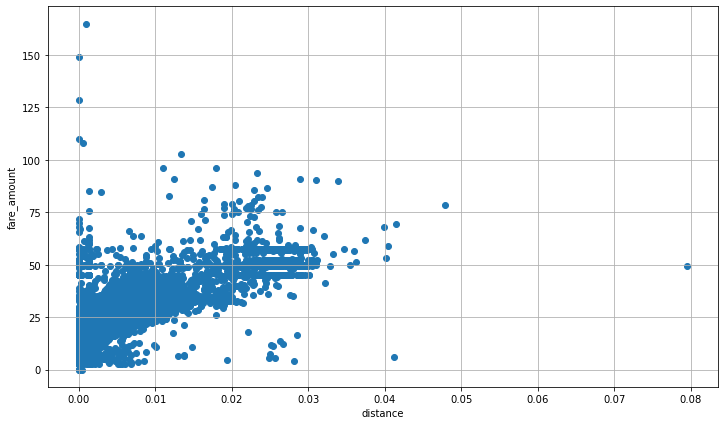

In [161]:
plt.figure(figsize=(12, 7))
plt.scatter(ny_df['distance'], ny_df['fare_amount'])
plt.xlabel('distance')
plt.ylabel('fare_amount')
plt.grid(True)
plt.show()

In [162]:
data = ny_df['distance'].to_numpy() # Serise를 Numpy의 array로 변환
target = ny_df['fare_amount'].to_numpy()

# data = ny_df['distance']
# target = ny_df['fare_amount']

data = data.reshape(-1,1) # 2차원 배열로 변경
target = target.reshape(-1,1) # 2차원 배열로 변경

In [163]:
# 학습용, 테스트용 데이터 분리
train_X, test_X, train_y, test_y = train_test_split(data, 
                                                    target,
                                                    test_size=0.2)

In [164]:
print(train_X.shape, test_X.shape)
print(train_y.shape, test_y.shape)

(39095, 1) (9774, 1)
(39095, 1) (9774, 1)


In [165]:
# 모델 객체 생성
model = LinearRegression()

In [166]:
# 학습 ==> 트레이닝 데이터 사용
# fit()메서드 => 2차원 형태 데이터
model.fit(train_X, train_y)

LinearRegression()

In [167]:
# 모델 파라미터 => w 가중치, b 절편
print('w : ', model.coef_, 'b : ', model.intercept_)

w :  [[1996.94650951]] b :  [8.6815636]


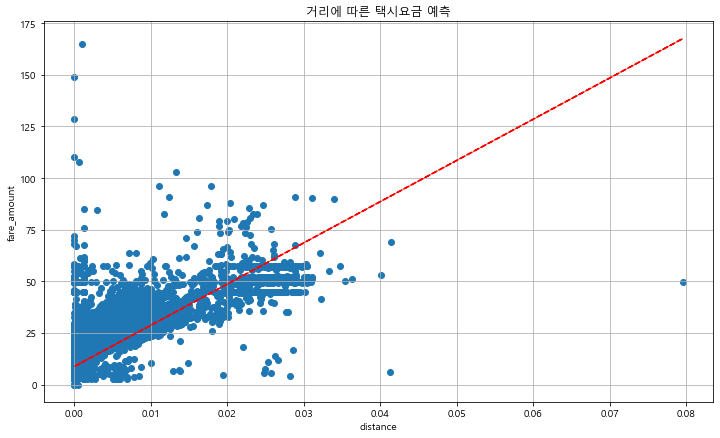

In [168]:
# 기울기와 절편을 이용한 1차 방정식 그래프
if platform.system() == 'Windows':
    plt.rc('font', family = 'Malgun Gothic')
elif platform.system() == 'Darwin': # MacOS
    plt.rc('font', family = 'AppleGothic')
else:
    plt.rc('font', family = 'AppleGothic')

plt.figure(figsize=(12,7))
plt.scatter(train_X, train_y)

# 1차 방정식 그래프 그리기
plt.plot(train_X,
        train_X*model.coef_ + model.intercept_,
        color = 'red', linestyle = '--')
plt.title('거리에 따른 택시요금 예측')
plt.xlabel('distance')
plt.ylabel('fare_amount')
plt.grid(True)
plt.show()

In [169]:
print('train data score: ',
     model.score(train_X, train_y))
print('test data score: ',
     model.score(test_X, test_y))

train data score:  0.649960980962552
test data score:  0.6758402122224352


# 2. 분류(Classification)

### [1] 데이터 로딩 및 확인

In [170]:
# 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np

In [171]:
# 데이터 로딩
FILE = './data/diabetes.csv'

df = pd.read_csv(FILE)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [172]:
# 결측치 개수 파악
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [173]:
# 기술 통계 정보 확인
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [174]:
# 각 컬럼당 0값을 제외한 컬럼의 평균 값으로 0 값 채우기
df.Glucose[df['Glucose']==0] = df.Glucose[df['Glucose']!=0].mean()
df.BloodPressure[df['BloodPressure']==0] = df.BloodPressure[df['BloodPressure']!=0].mean()
df.SkinThickness[df['SkinThickness']==0] = df.SkinThickness[df['SkinThickness']!=0].mean()
df.BMI[df['BMI']==0] = df.BMI[df['BMI']!=0].mean()

C:\Users\User\AppData\Local\Temp\ipykernel_12704\333754670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Glucose[df['Glucose']==0] = df.Glucose[df['Glucose']!=0].mean()
C:\Users\User\AppData\Local\Temp\ipykernel_12704\333754670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.BloodPressure[df['BloodPressure']==0] = df.BloodPressure[df['BloodPressure']!=0].mean()
C:\Users\User\AppData\Local\Temp\ipykernel_12704\333754670.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

### [2] 학습 데이터 준비

In [175]:
# 데이터 => Outcome 제외한 나머지 컬럼
# 타  겟 => 0, 1 (Outcome)

data = df.loc[:, df.columns[:-1]]
target = df.Outcome

In [176]:
print('data => ', data.shape)
print('target => ', target.shape)

data =>  (768, 8)
target =>  (768,)


In [177]:
# 학습용 , 테스트용 데이터 분리

# train:test=75%:25%
# test_size=0.X
# stratify => 분류 항목 비율 맞추어서 데이터셋 설정
# random_state => 매번 동일하게 데이터 구성하는 경우 지정
train_X, test_X, train_y, test_y = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=4)

In [178]:
# 모델 생성 학습
model = LogisticRegression()

In [179]:
# 학습
model.fit(train_X.values, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [180]:
# 학습 후 설정된 속성
print("분류 종류 : ", model.classes_)
print("가중치 값 : ", model.coef_)
print("절 편  값 : ", model.intercept_)
print("특성 갯수 : ", model.n_features_in_)

분류 종류 :  [0 1]
가중치 값 :  [[ 0.11235821  0.03856755 -0.01509113  0.01025378 -0.00331392  0.0998429
   2.58331239  0.01056145]]
절 편  값 :  [-9.74202485]
특성 갯수 :  8


In [181]:
# 평가 => score() 학습용 데이터 점수, 테스트용 데이터 점수
model.score(train_X, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.7899022801302932

In [182]:
# 테스트 => predict(): 새로운 데이터로 진행
preY = model.predict(train_X.values)

preY

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,

In [183]:
# 1개 데이터
preY = model.predict([[3.845052, 121.686763, 72.405184, 29.153420, 79.799479, 32.457464, 0.471876, 33.240885]])
print('예측결과 : ', preY)

예측결과 :  [0]


In [184]:
probaY = model.predict_proba([[3.845052, 121.686763, 72.405184, 29.153420, 79.799479, 32.457464, 0.471876, 33.240885]])
# print('분류항목 : ', model.classes_)
# print('예측확률 : ', probaY)
print(f'당뇨병 발병 확률이 {round(probaY[0][1]*100, 2)}%입니다.')

당뇨병 발병 확률이 29.64%입니다.
